## Regional Grain Size Model application and plots

Dan Buscombe May 2022

### Imports

In [123]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [9]:
import verde as vd
import pyproj
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

In [66]:
# from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import Polygon, box

### User-defined variables

In [322]:
dataset = 'model_data_out/ML_slope_wave_atlantic_2022-05-18_Data_Post2012_VerifiedOnshore_0.0015_right_transects.csv'
params = {
    "n_estimators": 500,
    "max_depth": 4,
    "min_samples_split": 10, #5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

test_size = 0.75 #0.6

### Load data and models

In [331]:
# tmp = np.load(dataset.replace('.csv','_stratsample5.npy'), allow_pickle=True)
# tmp = pd.read_csv(dataset.replace('.csv','_model_stratsample7.csv'))
tmp = pd.read_csv(dataset.replace('.csv','_model_stratsample8.csv'))
rand = np.load(dataset.replace('.csv','_rand.npy').replace('model_data_out','model_out'),allow_pickle=True)

In [332]:
model1out = np.load(dataset.replace('.csv','_model1.npy').replace('model_data_out','model_out'), allow_pickle=True).item(0)
model2out = np.load(dataset.replace('.csv','_model2.npy').replace('model_data_out','model_out'), allow_pickle=True).item(0)
model3out = np.load(dataset.replace('.csv','_model3.npy').replace('model_data_out','model_out'), allow_pickle=True).item(0)
model4out = np.load(dataset.replace('.csv','_model4.npy').replace('model_data_out','model_out'), allow_pickle=True).item(0)

In [339]:
tmp.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'hs_max', 'hs_mean', 'dir', 'tp',
       'latitude_left', 'latitude_left.1', 'longitude_left',
       'longitude_left.1', 'quality_flag_left', 'quality_flag_right', 'd50',
       'width_ci_average', 'beach_slope_average', 'beach_slope_median',
       'sl_points_average', 'mstr', 'prc_mstr_obs', 'min_tide_obs',
       'max_tide_obs', 'site_id', 'beach_slope', 'lower_conf_bound',
       'upper_conf_bound', 'width_ci', 'sl_points', 'trend', 'distance',
       'latitude', 'longitude', 'category_left', 'category_right'],
      dtype='object')

In [340]:
tmp = tmp.assign(rand=rand)

In [341]:
tmp.keys()

Index(['Unnamed: 0.1', 'Unnamed: 0', 'hs_max', 'hs_mean', 'dir', 'tp',
       'latitude_left', 'latitude_left.1', 'longitude_left',
       'longitude_left.1', 'quality_flag_left', 'quality_flag_right', 'd50',
       'width_ci_average', 'beach_slope_average', 'beach_slope_median',
       'sl_points_average', 'mstr', 'prc_mstr_obs', 'min_tide_obs',
       'max_tide_obs', 'site_id', 'beach_slope', 'lower_conf_bound',
       'upper_conf_bound', 'width_ci', 'sl_points', 'trend', 'distance',
       'latitude', 'longitude', 'category_left', 'category_right', 'rand'],
      dtype='object')

In [342]:
X_predict_all = np.vstack((tmp['beach_slope_median'],tmp['mstr'], tmp['rand']))
X_predict_all = X_predict_all[:,~np.isnan(X_predict_all).any(axis=0)]
X_predict_all[:,:].shape

ds_est_all = model2out['model'].predict(X_predict_all.T)

In [343]:
test,train = train_test_split(
    tmp, test_size=test_size, random_state=2022
)

Xtest = np.stack((test['beach_slope_median'],test['mstr'],test['rand']))

ds_est_test = model2out['model'].predict(Xtest.T)

Xtrain = np.stack((train['beach_slope_median'],train['mstr'],train['rand']))

ds_est_train = model2out['model'].predict(Xtrain.T)

(array([ 3.,  4.,  2., 16., 10.,  6.,  3.,  5.,  0.,  5.]),
 array([0.14431269, 0.23472862, 0.32514456, 0.41556049, 0.50597642,
        0.59639236, 0.68680829, 0.77722422, 0.86764016, 0.95805609,
        1.04847203]),
 <BarContainer object of 10 artists>)

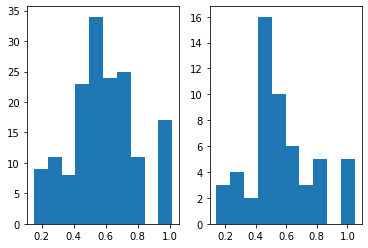

In [344]:
plt.subplot(121); plt.hist(ds_est_train)
plt.subplot(122); plt.hist(ds_est_test)

### Evaluation metrics

percent samples over 20% absolute error 

In [345]:
large_over = np.where(100*((tmp['d50']-ds_est_all)/tmp['d50'])>10)[0]
large_under = np.where(100*((tmp['d50']-ds_est_all)/tmp['d50'])<-10)[0]
print(len(large_over))
print(len(large_under))

100*((len(large_over) + len(large_under))/len(tmp))

19
37


25.925925925925924

### plotting objects

In [346]:
# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

In [347]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

### Regional point inputs

In [348]:
varss = ['beach_slope', 'd50', 'tp', 'mstr', 'hs_mean']
vmins = [0.01,.2,5,1,.2]
vmaxs = [.1,.8,9,2,.8]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 
          'Mean Spring Tidal Range (m)','Significant Wave Height (m)']

titles = ['a)', '', 'b)', 'c)', 'd)']

figs = ['model_input_plots/CGRASP_slope-map.jpg', 
        'model_input_plots/CGRASP_d50observed-map.jpg', 
        'model_input_plots/CGRASP_tp-map.jpg', 
        'model_input_plots/CGRASP_mstr-map.jpg', 
        'model_input_plots/CGRASP_hs-map.jpg']

/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


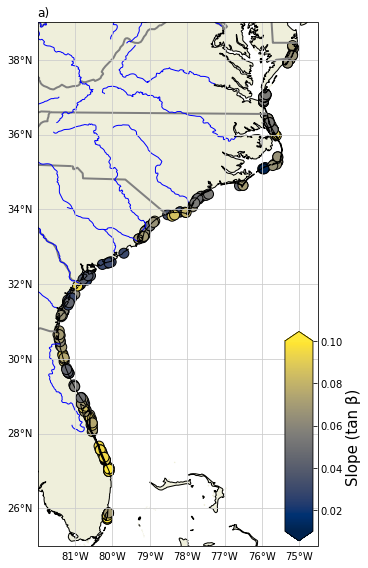

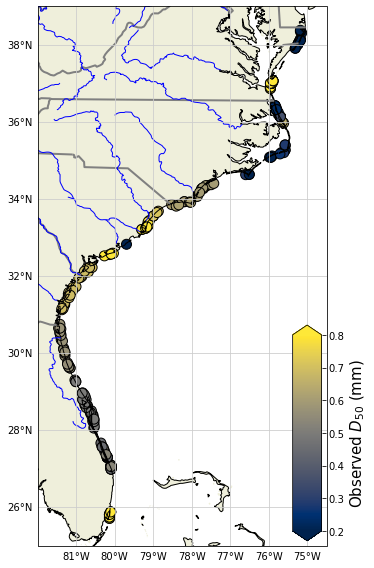

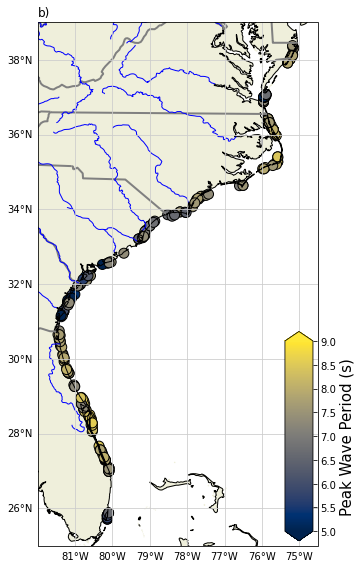

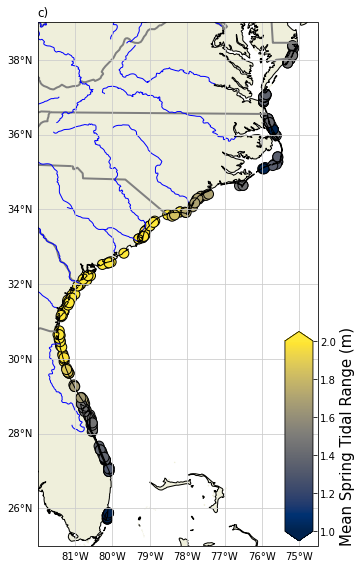

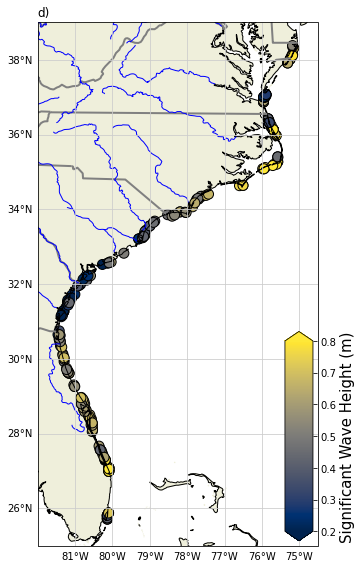

In [349]:
for var,outfile,vmin,vmax,label,title in zip(*[varss,figs,vmins,vmaxs,labels, titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([-82, -74.5, 25, 39], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(tmp['longitude'],tmp['latitude'],100,tmp[var], cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    plt.title(title, loc='left')
    # plt.legend(loc=4, fontsize=12)

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)
    
    plt.savefig(outfile, dpi=300, bbox_inches='tight')

In [350]:
!montage -geometry 2720x3764 -tile 2x2 model_input_plots/CGRASP_slope-map.jpg model_input_plots/CGRASP_mstr-map.jpg model_input_plots/CGRASP_tp-map.jpg model_input_plots/CGRASP_hs-map.jpg model_input_plots/model-inputs-maps_4panel.png
!montage -geometry 2720x3764 -tile 3x1 model_input_plots/CGRASP_slope-map.jpg model_input_plots/CGRASP_mstr-map.jpg model_input_plots/CGRASP_tp-map.jpg model_input_plots/model-inputs-maps_3panel.png

### Regional Model outputs

In [351]:
a = 100*((train['d50']-ds_est_train)/train['d50'])
b = 100*((test['d50']-ds_est_test)/test['d50'])
c = 100*((tmp['d50']-ds_est_all)/tmp['d50'])
d = ds_est_train
e = ds_est_test
f = ds_est_all
g = tmp['d50']
varss = [a,b,c,d,e,f,g]

xs = [train['longitude'],test['longitude'],tmp['longitude'],
      train['longitude'],test['longitude'],tmp['longitude'],tmp['longitude']]
ys = [train['latitude'],test['latitude'],tmp['latitude'],
      train['latitude'],test['latitude'],tmp['latitude'],tmp['latitude']]

vmins = [-10,-10,-10,.2,.2,.2,.2]
vmaxs = [10,10,10,.8,.8,.8,.8]

labels = ['Observed vs estimated $D_{50}$ (%)', 
          'Observed vs estimated $D_{50}$ (%)',
          'Observed vs estimated $D_{50}$ (%)',
          'Estimated $D_{50}$ (mm)',
          'Estimated $D_{50}$ (mm)',
          'Estimated $D_{50}$ (mm)',
          'Observed $D_{50}$ (mm)'
         ]

figs = ['model_output_plots/CGRASP_d50-slope-tide-predict-map-diff-train-set.jpg', 
        'model_output_plots/CGRASP_d50-slope-tide-predict-map-diff-test-set.jpg',
        'model_output_plots/CGRASP_d50-slope-tide-predict-map-diff.jpg',
        'model_output_plots/CGRASP_d50-slope-tide-predict-map_train_set.jpg',
        'model_output_plots/CGRASP_d50-slope-tide-predict-map_test_set.jpg',
        'model_output_plots/CGRASP_d50-slope-tide-predict-map.jpg',
        'model_output_plots/CGRASP_d50-observed-map.jpg'
       ]

titles=['c)','c)','c)','c)','b)','b)','a)']

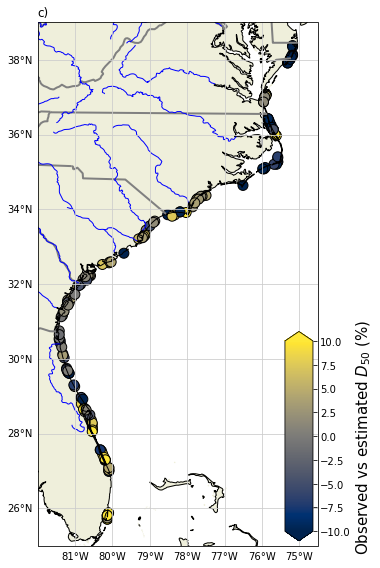

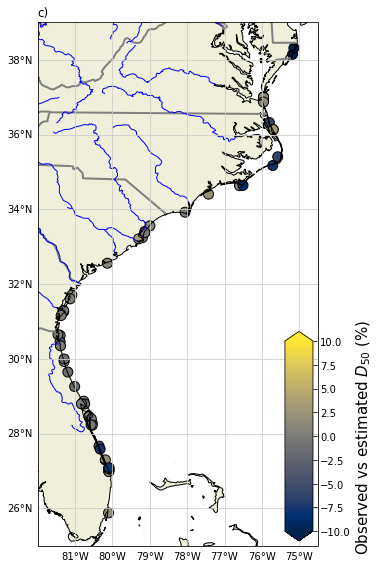

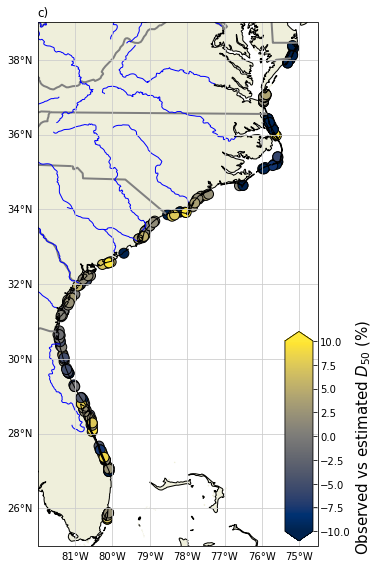

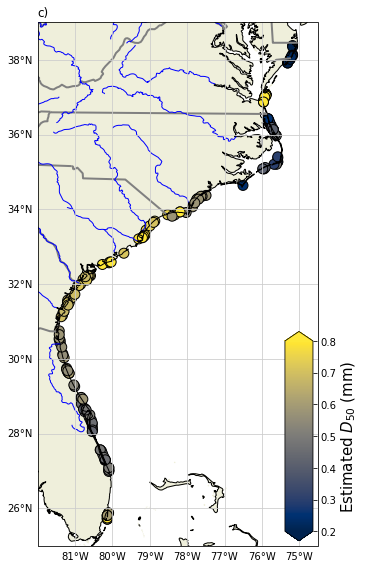

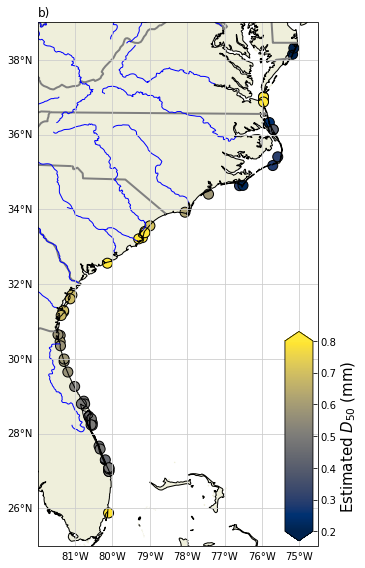

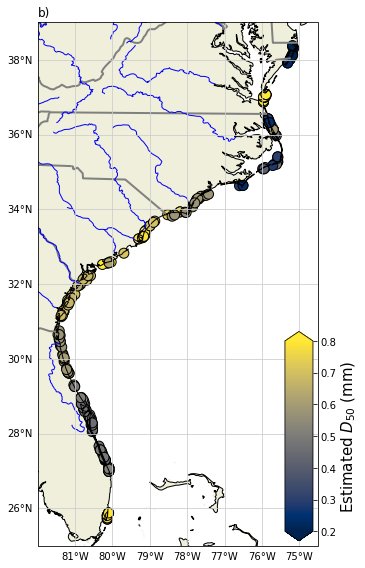

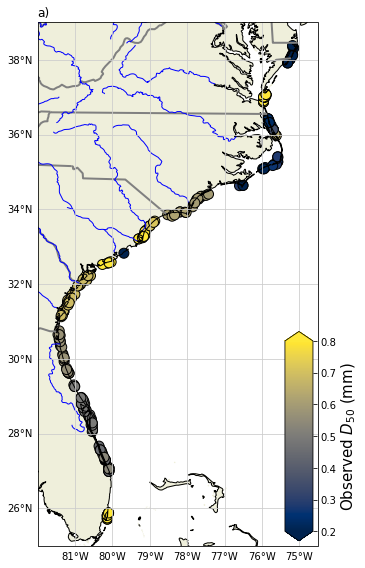

In [352]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(16,8))
    ax = plt.axes(projection=crs)
    ax.set_extent([-82, -74.5, 25, 39], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
#     cb.set_label(label, fontsize=15)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)
    
    plt.savefig(outfile, dpi=300, bbox_inches='tight')


In [353]:
# !montage -geometry 2720x3764 -tile 3x1 model_output_plots/CGRASP_d50-slope-tide-predict-map-diff.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map-diff-test-set.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map-diff-train-set.jpg model_output_plots/d50-maps_3panel_test_train-diffs.png
!montage -geometry 2720x3764 -tile 3x1 model_output_plots/CGRASP_d50-observed-map.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map_test_set.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map_train_set.jpg model_output_plots/d50-maps_3panel_test_train.png
!montage -geometry 2720x3764 -tile 3x1 model_output_plots/CGRASP_d50-observed-map.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map.jpg model_output_plots/CGRASP_d50-slope-tide-predict-map-diff.jpg model_output_plots/d50-maps_3panel.png

## Regional Gridded outputs

In [354]:
coordinates = (tmp.longitude.values, tmp.latitude.values)

# Use a Mercator projection for our Cartesian gridder
projection = pyproj.Proj(proj="merc", lat_ts=tmp.latitude.mean())


In [355]:
spacing = 2 / 60  # 5 arc-minutes
chain = vd.Chain(
    [
        ("mean", vd.BlockMean(spacing=spacing*111e3 , uncertainty=False)), #True *111e3
        ("spline", vd.Spline(damping=1e-10)),
    ]
)
print(chain)

Chain(steps=[('mean', BlockMean(spacing=3700.0)),
             ('spline', Spline(damping=1e-10))])


In [356]:
# Split the data into a training and testing set. We'll use the training set to
# grid the data and the testing set to validate our spline model. Weights need
# to 1/uncertainty**2 for the error propagation in BlockMean to work.
train, test = vd.train_test_split(
    projection(*coordinates),
    tmp.d50,
    weights=None, #1 / tmp.mstr**2,
    random_state=0,
)

# Fit the model on the training set
chain.fit(*train)
# And calculate an R^2 score coefficient on the testing set. The best possible
# score (perfect prediction) is 1. This can tell us how good our spline is at
# predicting data that was not in the input dataset.
score = chain.score(*test)
print("\nScore: {:.3f}".format(score))

# Create a grid of the vertical velocity and mask it to only show points close
# to the actual data.
region = vd.get_region(coordinates)
grid_full = chain.grid(
    region=region,
    spacing=spacing,
    projection=projection,
    dims=["latitude", "longitude"],
    data_names=["d50 (mm)"],
)

grid = vd.convexhull_mask(
    (tmp.longitude, tmp.latitude), grid=grid_full, projection=projection
)


Score: 0.998


/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/verde/base/base_classes.py:359: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  warnings.warn(
/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/verde/base/base_classes.py:463: FutureWarning: The 'spacing', 'shape' and 'region' arguments will be removed in Verde v2.0.0. Please use the 'verde.grid_coordinates' function to define grid coordinates and pass them as the 'coordinates' argument.
  warnings.warn(


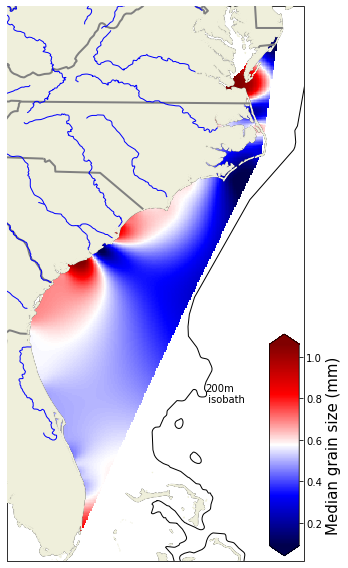

In [357]:

crs = ccrs.PlateCarree()
fig=plt.figure(figsize=(16,8))
ax = plt.axes(projection=crs)
ax.set_extent([-82, -74.5, 25, 39], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')

ax.add_feature(cfeature.LAND, zorder=100)
# ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray', lw=2, zorder=100)
# ax.add_feature(cfeature.OCEAN, zorder=0, alpha=0.5)

bathym = cfeature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical')
ax.add_feature(bathym, facecolor='none', edgecolor='black', zorder=100)

ax.add_feature(rivers_50m, facecolor='None', edgecolor='b', zorder=100)

ax.text(-77, 29, '200m\n isobath', transform=ccrs.Geodetic())

# gl = ax.gridlines(draw_labels=True, color='.8')

# gl.xlabels_top = False
# gl.ylabels_right = False
# # gl.xlines = False

# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'black'}
# gl.ylabel_style = {'size': 15, 'color': 'black'}

maxabs = vd.maxabs(tmp.d50) 
pc = (grid['d50 (mm)'] ).plot.pcolormesh(
    ax=ax,
    cmap="seismic",
    vmin=tmp.d50.min(),
    vmax=tmp.d50.max(),
    transform=crs,
    add_colorbar=False,
    add_labels=False,
    zorder=-1)
# cb = plt.colorbar(pc, ax=ax, orientation="vertical", pad=0.05, shrink=.75, extend='both')
# cb.set_label("Median grain size [mm]")
# im = ax.scatter(*coordinates, c="black", s=50, alpha=0.1, transform=crs)
# cb.set_label('Median grain size (mm)', fontsize=15)

fig.tight_layout()
cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
cb=plt.colorbar(pc, cax=cbaxes,extend='both')#, shrink=0.5)
cb.set_label('Median grain size (mm)', fontsize=15)

plt.savefig('model_output_plots/CGRASP_estimated_d50_grid.jpg', dpi=300, bbox_inches='tight')

## State by state

In [358]:
states = gpd.read_file('data/usa-states-census-2014.shp')

In [359]:
tmpgeo = gpd.GeoDataFrame(tmp, geometry=gpd.points_from_xy(tmp.longitude, tmp.latitude))

In [360]:
FL =  states[states.NAME == "Florida"]
boundsFL = FL['geometry'].bounds.values[0]
b = box(boundsFL[0],boundsFL[1],boundsFL[2],boundsFL[3])

polygon = Polygon(list(b.exterior.coords))

data_FL = tmpgeo.clip(polygon)

In [361]:
GA =  states[states.NAME == "Georgia"]
boundsGA = GA['geometry'].bounds.values[0]
b = box(boundsGA[0],boundsGA[1],boundsGA[2],boundsGA[3])

polygon = Polygon(list(b.exterior.coords))

data_GA = tmpgeo.clip(polygon)

In [362]:
SC =  states[states.NAME == "South Carolina"]
boundsSC = SC['geometry'].bounds.values[0]
b = box(boundsSC[0],boundsSC[1],boundsSC[2],boundsSC[3])

polygon = Polygon(list(b.exterior.coords))

data_SC = tmpgeo.clip(polygon)

In [363]:
NC =  states[states.NAME == "North Carolina"]
boundsNC = NC['geometry'].bounds.values[0]
b = box(boundsNC[0],boundsNC[1],boundsNC[2],boundsNC[3])

polygon = Polygon(list(b.exterior.coords))

data_NC = tmpgeo.clip(polygon)

In [364]:
VA =  states[states.NAME == "Virginia"]
boundsVA = VA['geometry'].bounds.values[0]
b = box(boundsVA[0],boundsVA[1],boundsVA[2],boundsVA[3])

polygon = Polygon(list(b.exterior.coords))

data_VA = tmpgeo.clip(polygon)

In [365]:
print("Samples in Florida: {}".format(len(data_FL)))
print("Samples in Georgia: {}".format(len(data_GA)))
print("Samples in SC: {}".format(len(data_SC)))
print("Samples in NC: {}".format(len(data_NC)))
print("Samples in VA: {}".format(len(data_VA)))

Samples in Florida: 87
Samples in Georgia: 30
Samples in SC: 28
Samples in NC: 48
Samples in VA: 22


### FL

In [366]:
a=tmp['beach_slope']
b=tmp['d50']
c=ds_est_all
d=tmp['tp']
e=tmp['mstr']
varss = [a,b,c,d,e]

xs = [tmp['longitude'],tmp['longitude'],tmp['longitude'],
      tmp['longitude'],tmp['longitude']]
ys = [tmp['latitude'],tmp['latitude'],tmp['latitude'],
      tmp['latitude'],tmp['latitude']]

vmins = [0.01,.2,.2,5,1]
vmaxs = [.1,.8,.8,9,2]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 
          'Estimated $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Spring Tidal Range (m)']

figs = ['model_input_plots/CGRASP_slope-map_FL.jpg', 
        'model_input_plots/CGRASP_d50observed-map_FL.jpg', 
        'model_input_plots/CGRASP_d50estimated-map_FL.jpg', 
        'model_input_plots/CGRASP_tp-map_FL.jpg', 
        'model_input_plots/CGRASP_mstr-map_FL.jpg']

# titles = ['c)','a)','b)','e)','d)']
titles = ['w)','u)','v)','y)','x)']

In [367]:
boundsFL

array([-87.634943,  24.498131, -80.03212 ,  31.000693])

/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/marda/anaconda3/envs/cgrasp/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


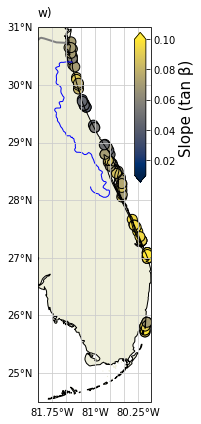

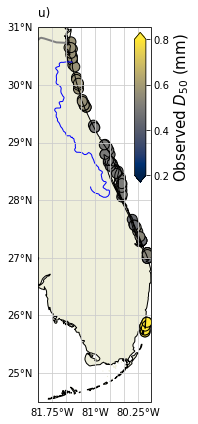

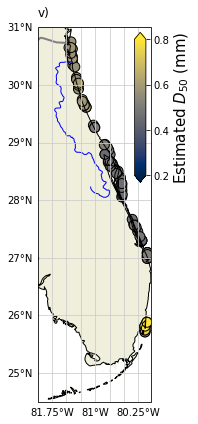

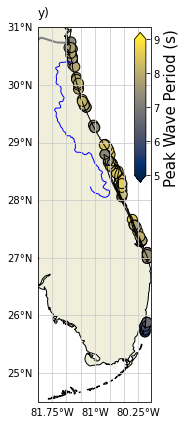

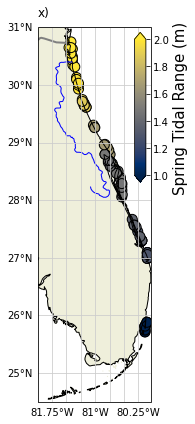

In [368]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(10,6))
    ax = plt.axes(projection=crs)
    ax.set_extent([-82, boundsFL[2], boundsFL[1], boundsFL[3]], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=1) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### GA

In [369]:
# varss = ['beach_slope', 'd50', 'tp', 'mstr']
# vmins = [0.01,.2,5,1]
# vmaxs = [.1,.8,9,2]
# labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Mean Spring Tidal Range (m)']
# figs = ['model_input_plots/CGRASP_slope-map_GA.jpg', 
#         'model_input_plots/CGRASP_d50observed-map_GA.jpg', 
#         'model_input_plots/CGRASP_tp-map_GA.jpg', 
#         'model_input_plots/CGRASP_mstr-map_GA.jpg']

a=tmp['beach_slope']
b=tmp['d50']
c=ds_est_all
d=tmp['tp']
e=tmp['mstr']
varss = [a,b,c,d,e]

xs = [tmp['longitude'],tmp['longitude'],tmp['longitude'],
      tmp['longitude'],tmp['longitude']]
ys = [tmp['latitude'],tmp['latitude'],tmp['latitude'],
      tmp['latitude'],tmp['latitude']]

vmins = [0.01,.2,.2,5,1]
vmaxs = [.1,.8,.8,9,2]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 
          'Estimated $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Spring Tidal Range (m)']

figs = ['model_input_plots/CGRASP_slope-map_GA.jpg', 
        'model_input_plots/CGRASP_d50observed-map_GA.jpg', 
        'model_input_plots/CGRASP_d50estimated-map_GA.jpg', 
        'model_input_plots/CGRASP_tp-map_GA.jpg', 
        'model_input_plots/CGRASP_mstr-map_GA.jpg']

titles = ['r)','p)','q)','t)','s)']

In [370]:
boundsGA

array([-85.605165,  30.360766, -80.84313 ,  35.000659])

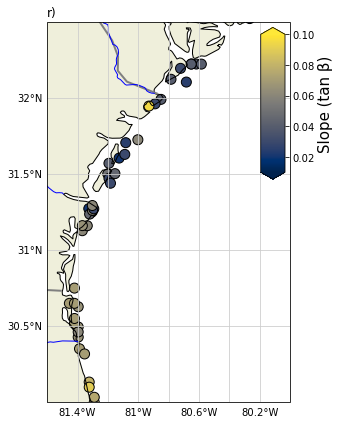

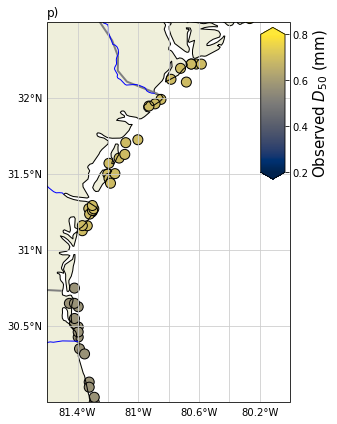

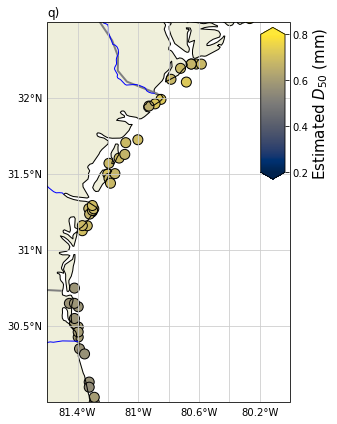

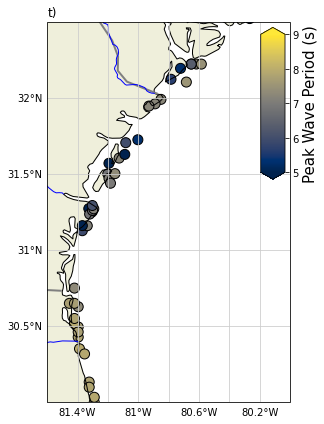

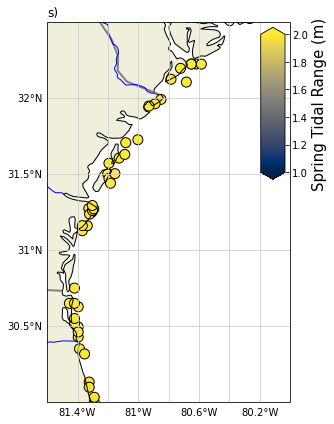

In [371]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(10,6))
    ax = plt.axes(projection=crs)
    ax.set_extent([-81.6, -80, 30, 32.5], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=1) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### SC

In [372]:
# varss = ['beach_slope', 'd50', 'tp', 'mstr']
# vmins = [0.01,.2,5,1]
# vmaxs = [.1,.8,9,2]
# labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Mean Spring Tidal Range (m)']
# figs = ['model_input_plots/CGRASP_slope-map_SC.jpg', 
#         'model_input_plots/CGRASP_d50observed-map_SC.jpg', 
#         'model_input_plots/CGRASP_tp-map_SC.jpg', 
#         'model_input_plots/CGRASP_mstr-map_SC.jpg']

a=tmp['beach_slope']
b=tmp['d50']
c=ds_est_all
d=tmp['tp']
e=tmp['mstr']
varss = [a,b,c,d,e]

xs = [tmp['longitude'],tmp['longitude'],tmp['longitude'],
      tmp['longitude'],tmp['longitude']]
ys = [tmp['latitude'],tmp['latitude'],tmp['latitude'],
      tmp['latitude'],tmp['latitude']]

vmins = [0.01,.2,.2,5,1]
vmaxs = [.1,.8,.8,9,2]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 
          'Estimated $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Spring Tidal Range (m)']

figs = ['model_input_plots/CGRASP_slope-map_SC.jpg', 
        'model_input_plots/CGRASP_d50observed-map_SC.jpg', 
        'model_input_plots/CGRASP_d50estimated-map_SC.jpg', 
        'model_input_plots/CGRASP_tp-map_SC.jpg', 
        'model_input_plots/CGRASP_mstr-map_SC.jpg']

titles = ['m)','k)','l)','o)','n)']

In [373]:
boundsSC

array([-83.353238,  32.0346  , -78.541087,  35.202483])

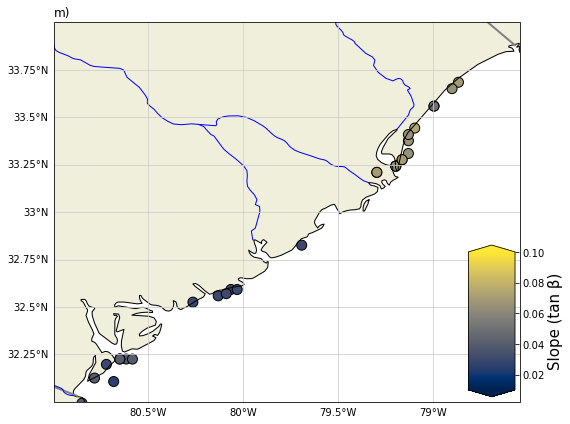

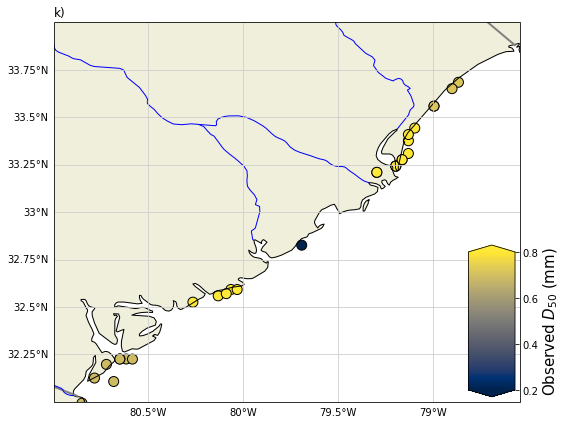

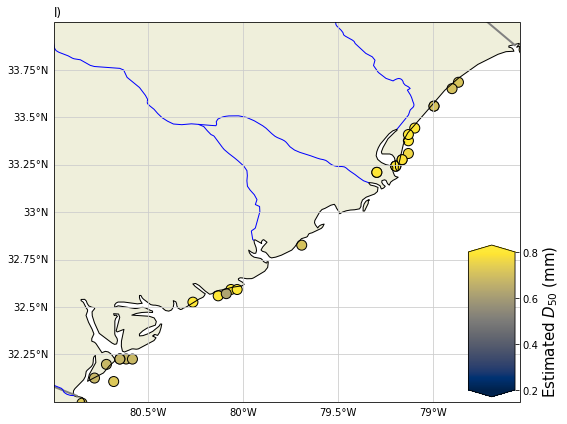

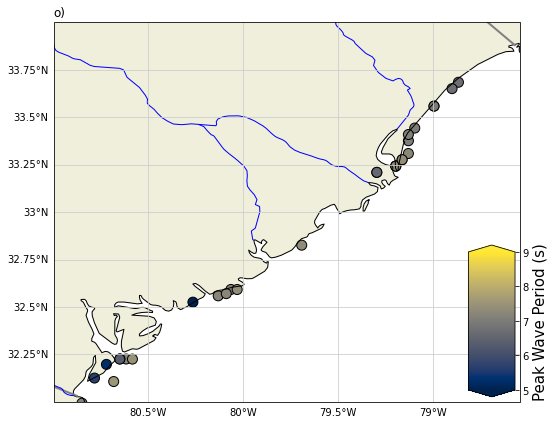

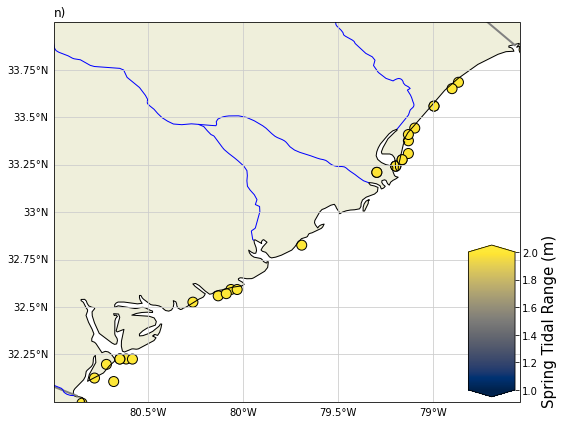

In [374]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(10,6))
    ax = plt.axes(projection=crs)
    ax.set_extent([-81, boundsSC[2], 32, 34], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### NC

In [375]:
# varss = ['beach_slope', 'd50', 'tp', 'mstr']
# vmins = [0.01,.2,5,1]
# vmaxs = [.1,.8,9,2]
# labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Mean Spring Tidal Range (m)']
# figs = ['model_input_plots/CGRASP_slope-map_NC.jpg', 
#         'model_input_plots/CGRASP_d50observed-map_NC.jpg', 
#         'model_input_plots/CGRASP_tp-map_NC.jpg', 
#         'model_input_plots/CGRASP_mstr-map_NC.jpg']

a=tmp['beach_slope']
b=tmp['d50']
c=ds_est_all
d=tmp['tp']
e=tmp['mstr']
varss = [a,b,c,d,e]

xs = [tmp['longitude'],tmp['longitude'],tmp['longitude'],
      tmp['longitude'],tmp['longitude']]
ys = [tmp['latitude'],tmp['latitude'],tmp['latitude'],
      tmp['latitude'],tmp['latitude']]

vmins = [0.01,.2,.2,5,1]
vmaxs = [.1,.8,.8,9,2]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 
          'Estimated $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Spring Tidal Range (m)']

figs = ['model_input_plots/CGRASP_slope-map_NC.jpg', 
        'model_input_plots/CGRASP_d50observed-map_NC.jpg', 
        'model_input_plots/CGRASP_d50estimated-map_NC.jpg', 
        'model_input_plots/CGRASP_tp-map_NC.jpg', 
        'model_input_plots/CGRASP_mstr-map_NC.jpg']

titles = ['h)','f)','g)','j)','i)']

In [376]:
boundsNC

array([-84.321869,  33.851112, -75.458659,  36.588117])

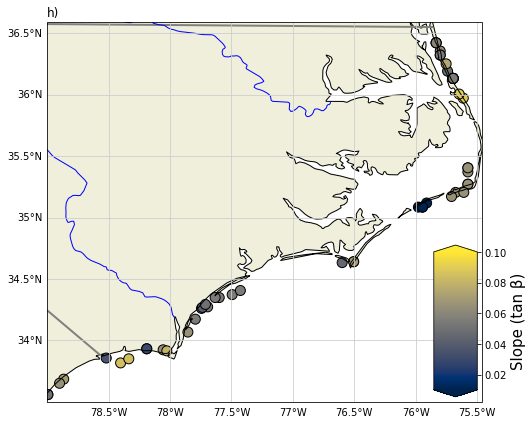

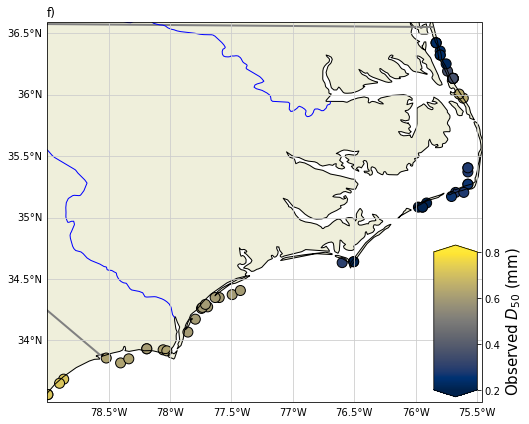

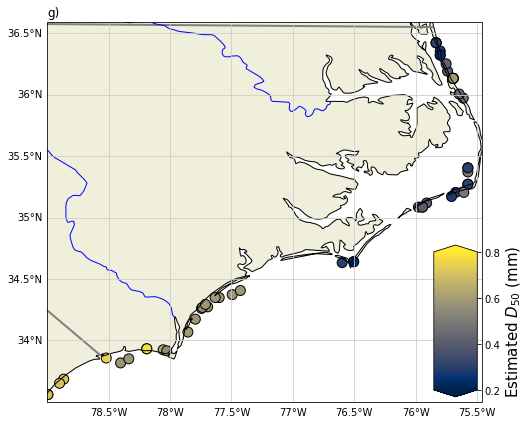

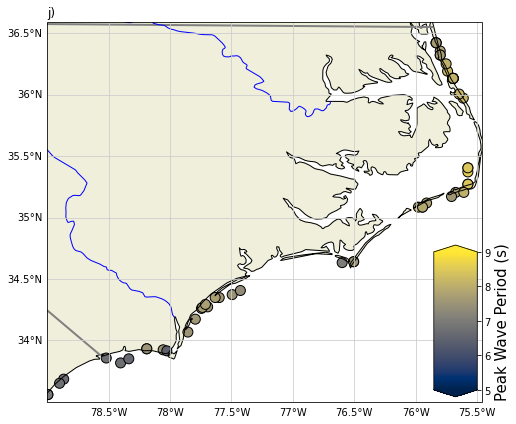

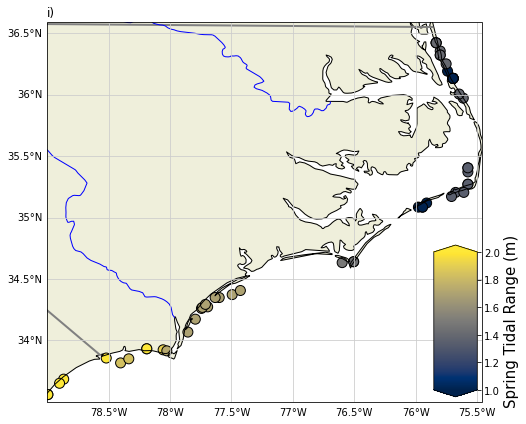

In [377]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(10,6))
    ax = plt.axes(projection=crs)
    ax.set_extent([-79, boundsNC[2], 33.5, boundsNC[3]], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### VA

In [378]:
# varss = ['beach_slope', 'd50', 'tp', 'mstr']
# vmins = [0.01,.2,5,1]
# vmaxs = [.1,.8,9,2]
# labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Mean Spring Tidal Range (m)']
# figs = ['model_input_plots/CGRASP_slope-map_VA.jpg', 
#         'model_input_plots/CGRASP_d50observed-map_VA.jpg', 
#         'model_input_plots/CGRASP_tp-map_VA.jpg', 
#         'model_input_plots/CGRASP_mstr-map_VA.jpg']

a=tmp['beach_slope']
b=tmp['d50']
c=ds_est_all
d=tmp['tp']
e=tmp['mstr']
varss = [a,b,c,d,e]

xs = [tmp['longitude'],tmp['longitude'],tmp['longitude'],
      tmp['longitude'],tmp['longitude']]
ys = [tmp['latitude'],tmp['latitude'],tmp['latitude'],
      tmp['latitude'],tmp['latitude']]

vmins = [0.01,.2,.2,5,1]
vmaxs = [.1,.8,.8,9,2]

labels = ['Slope (tan β)', 'Observed $D_{50}$ (mm)', 
          'Estimated $D_{50}$ (mm)', 'Peak Wave Period (s)', 'Spring Tidal Range (m)']

figs = ['model_input_plots/CGRASP_slope-map_VA.jpg', 
        'model_input_plots/CGRASP_d50observed-map_VA.jpg', 
        'model_input_plots/CGRASP_d50estimated-map_VA.jpg', 
        'model_input_plots/CGRASP_tp-map_VA.jpg', 
        'model_input_plots/CGRASP_mstr-map_VA.jpg']

titles = ['c)','a)','b)','e)','d)']

In [379]:
boundsVA

array([-83.675413,  36.540738, -75.242266,  39.466012])

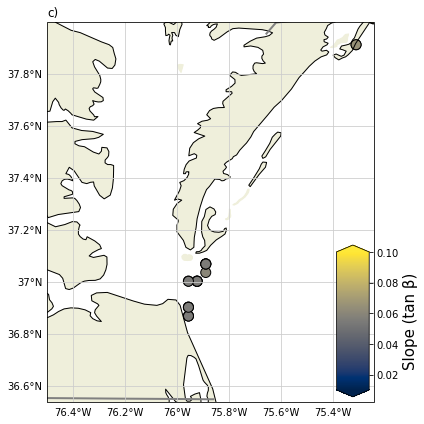

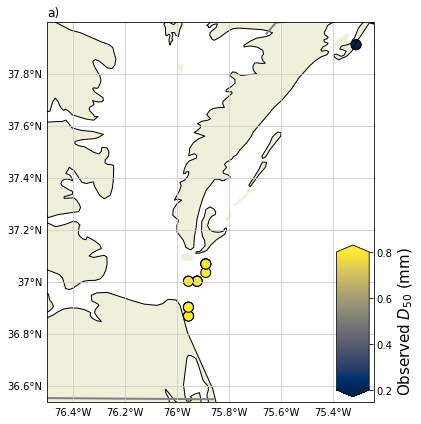

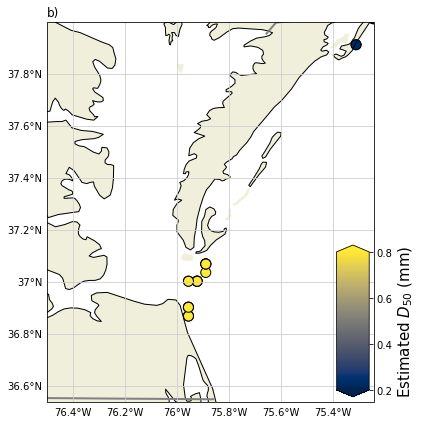

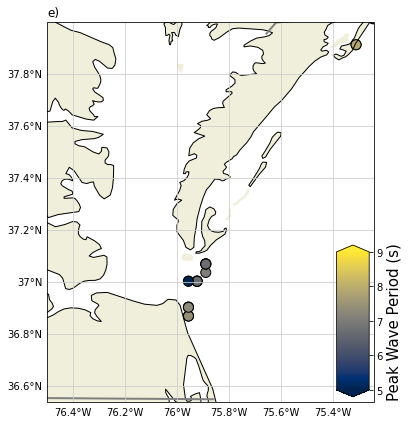

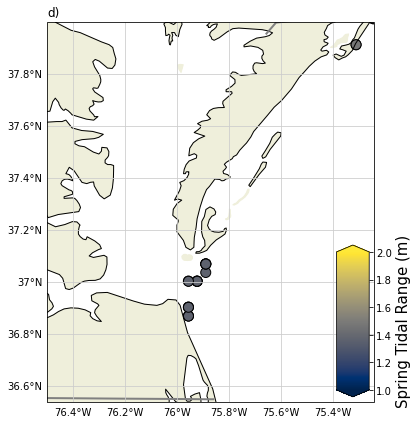

In [380]:
for var,outfile,vmin,vmax,label,x,y,title in zip(*[varss,figs,vmins,vmaxs,labels,xs,ys,titles]):

    crs = ccrs.PlateCarree()
    fig=plt.figure(figsize=(10,6))
    ax = plt.axes(projection=crs)
    ax.set_extent([-76.5, boundsVA[2], boundsVA[1], 38], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')

    ax.add_feature(cfeature.LAND)#, zorder=100)
    ax.add_feature(states_provinces, edgecolor='gray', lw=2)#, zorder=100)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')#, zorder=100)
    gl = ax.gridlines(draw_labels=True, color='.8')

    gl.xlabels_top = False
    gl.ylabels_right = False
    # gl.xlines = False

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}

    plt.scatter(x,y,100,var, cmap='cividis', 
                vmin=vmin, vmax=vmax, lw=1,edgecolors='black')
    # plt.legend(loc=4, fontsize=12)
#     cb=plt.colorbar(extend='both', shrink=0.5)
    plt.title(title, loc='left')

    fig.tight_layout()
    cbaxes = inset_axes(ax, width="10%", height="40%", loc=4) 
    cb=plt.colorbar(cax=cbaxes,extend='both')#, shrink=0.5)
    cb.set_label(label, fontsize=15)

    plt.savefig(outfile, dpi=300, bbox_inches='tight')

### merge states plots

In [381]:
!montage -geometry 2720x2720 -tile 5x1 model_input_plots/CGRASP_d50observed-map_VA.jpg model_input_plots/CGRASP_d50estimated-map_VA.jpg model_input_plots/CGRASP_slope-map_VA.jpg model_input_plots/CGRASP_mstr-map_VA.jpg model_input_plots/CGRASP_tp-map_VA.jpg model_input_plots/model-inputs-maps_5panel_VA.png
!montage -geometry 2720x2720 -tile 5x1 model_input_plots/CGRASP_d50observed-map_NC.jpg model_input_plots/CGRASP_d50estimated-map_NC.jpg model_input_plots/CGRASP_slope-map_NC.jpg model_input_plots/CGRASP_mstr-map_NC.jpg model_input_plots/CGRASP_tp-map_NC.jpg model_input_plots/model-inputs-maps_5panel_NC.png
!montage -geometry 2720x2720 -tile 5x1 model_input_plots/CGRASP_d50observed-map_SC.jpg model_input_plots/CGRASP_d50estimated-map_SC.jpg model_input_plots/CGRASP_slope-map_SC.jpg model_input_plots/CGRASP_mstr-map_SC.jpg model_input_plots/CGRASP_tp-map_SC.jpg model_input_plots/model-inputs-maps_5panel_SC.png
!montage -geometry 2720x2720 -tile 5x1 model_input_plots/CGRASP_d50observed-map_GA.jpg model_input_plots/CGRASP_d50estimated-map_GA.jpg model_input_plots/CGRASP_slope-map_GA.jpg model_input_plots/CGRASP_mstr-map_GA.jpg model_input_plots/CGRASP_tp-map_GA.jpg model_input_plots/model-inputs-maps_5panel_GA.png
!montage -geometry 2720x2720 -tile 5x1 model_input_plots/CGRASP_d50observed-map_FL.jpg model_input_plots/CGRASP_d50estimated-map_FL.jpg model_input_plots/CGRASP_slope-map_FL.jpg model_input_plots/CGRASP_mstr-map_FL.jpg model_input_plots/CGRASP_tp-map_FL.jpg model_input_plots/model-inputs-maps_5panel_FL.png

In [382]:
!montage -geometry 1360x1882 -tile 1x5  model_input_plots/model-inputs-maps_5panel_VA.png model_input_plots/model-inputs-maps_5panel_NC.png model_input_plots/model-inputs-maps_5panel_SC.png model_input_plots/model-inputs-maps_5panel_GA.png model_input_plots/model-inputs-maps_5panel_FL.png model_input_plots/model-inputs-maps_5panel_allstates.png

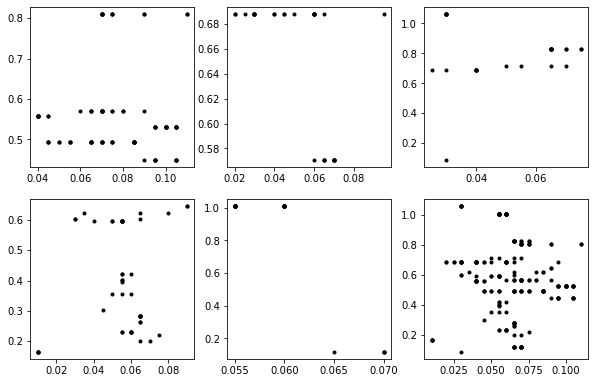

In [383]:
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(data_FL['beach_slope'], data_FL['d50'],'k.')

plt.subplot(332)
plt.plot(data_GA['beach_slope'], data_GA['d50'],'k.')

plt.subplot(333)
plt.plot(data_SC['beach_slope'], data_SC['d50'],'k.')

plt.subplot(334)
plt.plot(data_NC['beach_slope'], data_NC['d50'],'k.')

plt.subplot(335)
plt.plot(data_VA['beach_slope'], data_VA['d50'],'k.')

plt.subplot(336)
plt.plot(tmp['beach_slope'], tmp['d50'],'k.')

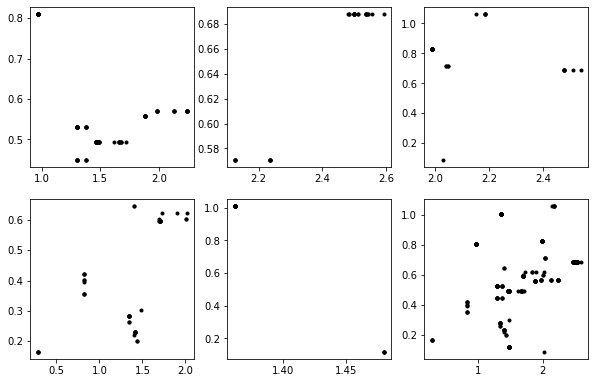

In [384]:
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(data_FL['mstr'], data_FL['d50'],'k.')

plt.subplot(332)
plt.plot(data_GA['mstr'], data_GA['d50'],'k.')

plt.subplot(333)
plt.plot(data_SC['mstr'], data_SC['d50'],'k.')

plt.subplot(334)
plt.plot(data_NC['mstr'], data_NC['d50'],'k.')

plt.subplot(335)
plt.plot(data_VA['mstr'], data_VA['d50'],'k.')

plt.subplot(336)
plt.plot(tmp['mstr'], tmp['d50'],'k.')

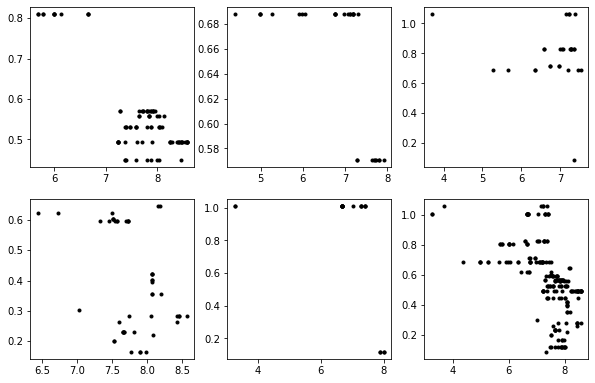

In [385]:
plt.figure(figsize=(10,10))
plt.subplot(331)
plt.plot(data_FL['tp'], data_FL['d50'],'k.')

plt.subplot(332)
plt.plot(data_GA['tp'], data_GA['d50'],'k.')

plt.subplot(333)
plt.plot(data_SC['tp'], data_SC['d50'],'k.')

plt.subplot(334)
plt.plot(data_NC['tp'], data_NC['d50'],'k.')

plt.subplot(335)
plt.plot(data_VA['tp'], data_VA['d50'],'k.')

plt.subplot(336)
plt.plot(tmp['tp'], tmp['d50'],'k.')